In [739]:
#Загружаем библиотки и датафрейм
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              


import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('Recipt_2019_2020.csv', sep =";", header = None)
df.head()
df.dtypes

0      int64
1     object
2      int64
3    float64
4     object
5     object
dtype: object

In [802]:
#Проводим тест на стационарность

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

def get_adf_kpss(data):
    
    dftest = adfuller(data)
    print(f'adf stat: {dftest[0]}')
    print(f'adf p-value: {dftest[1]}')
    
    kpss_test = kpss(data)
    print(f'kpss stat: {kpss_test[0]}')
    print(f'kpss p-value: {kpss_test[1]}')
    
    if dftest[0] > dftest[4]['5%'] and kpss_test[0] < kpss_test[3]['5%']:
        print('Временной ряд не стационарен')
        
    if dftest[0] < dftest[4]['5%'] and kpss_test[0] > kpss_test[3]['5%']:
        print('Временной ряд стационарен')
        
    if dftest[0] > dftest[4]['5%'] and kpss_test[0] > kpss_test[3]['5%']:
        print('Врменной ряд имеет тренд и стационарность. Необходимо удалить тренд')
        
    if dftest[0] < dftest[4]['5%'] and kpss_test[0] < kpss_test[3]['5%']:   
        print(' \n Ряд стационарен необходимо провести дифференцирование')
        

In [740]:
data = pd.read_csv('Recipt_2019_2020.csv', sep = ';', header = None)
data.head()

,0,1,2,3,4,5
0,714,2019-01-01,2,7995.0,Гипермаркет,Дон
1,715,2019-01-01,1,13438.0,Гипермаркет,Дон
2,715,2019-01-01,1,13438.0,Гипермаркет,Дон
3,714,2019-01-01,1,7995.0,Гипермаркет,Дон
4,733,2019-01-01,1,7107.0,Гипермаркет,Москва


In [741]:
data.columns = ['BU','date_recipt','quantity_recipt','store_square','square_format','RegionalOffice']
data.head()

,BU,date_recipt,quantity_recipt,store_square,square_format,RegionalOffice
0,714,2019-01-01,2,7995.0,Гипермаркет,Дон
1,715,2019-01-01,1,13438.0,Гипермаркет,Дон
2,715,2019-01-01,1,13438.0,Гипермаркет,Дон
3,714,2019-01-01,1,7995.0,Гипермаркет,Дон
4,733,2019-01-01,1,7107.0,Гипермаркет,Москва


In [742]:
data['year'] = pd.to_datetime(data['date_recipt']).dt.year
data['month'] = pd.to_datetime(data['date_recipt']).dt.month
data['day'] = pd.to_datetime(data['date_recipt']).dt.day

#data['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
#df.head()
data.head()

,BU,date_recipt,quantity_recipt,store_square,square_format,RegionalOffice,year,month,day
0,714,2019-01-01,2,7995.0,Гипермаркет,Дон,2019,1,1
1,715,2019-01-01,1,13438.0,Гипермаркет,Дон,2019,1,1
2,715,2019-01-01,1,13438.0,Гипермаркет,Дон,2019,1,1
3,714,2019-01-01,1,7995.0,Гипермаркет,Дон,2019,1,1
4,733,2019-01-01,1,7107.0,Гипермаркет,Москва,2019,1,1


In [743]:
data.set_index('date_recipt', inplace = True)
data.sort_index()

,BU,quantity_recipt,store_square,square_format,RegionalOffice,year,month,day
date_recipt,,,,,,,,
2019-01-01,714,2,7995.0,Гипермаркет,Дон,2019,1,1
2019-01-01,715,1,13438.0,Гипермаркет,Дон,2019,1,1
2019-01-01,715,1,13438.0,Гипермаркет,Дон,2019,1,1
2019-01-01,714,1,7995.0,Гипермаркет,Дон,2019,1,1
2019-01-01,733,1,7107.0,Гипермаркет,Москва,2019,1,1
...,...,...,...,...,...,...,...,...
2020-12-31,713,110,13035.0,Гипермаркет,Юг,2020,12,31
2020-12-31,713,117,13035.0,Гипермаркет,Юг,2020,12,31
2020-12-31,803,80,9571.0,Гипермаркет,Юг,2020,12,31


In [744]:
#Основные cтатистики
data.describe()

,BU,quantity_recipt,store_square,year,month,day
count,196249.000000,196249.000000,196249.000000,196249.000000,196249.000000,196249.000000
mean,733.680870,31.157519,9685.898308,2019.578296,6.697991,15.799637
std,39.926486,36.549022,2820.466529,0.493833,3.590786,8.775565
min,201.000000,1.000000,0.000000,2019.000000,1.000000,1.000000
25%,716.000000,3.000000,7483.000000,2019.000000,3.000000,8.000000
50%,727.000000,17.000000,9571.000000,2020.000000,7.000000,16.000000
75%,737.000000,49.000000,11697.000000,2020.000000,10.000000,23.000000
max,811.000000,769.000000,16746.000000,2020.000000,12.000000,31.000000


In [745]:
len(data['BU'].drop_duplicates())

34

In [746]:
len(data['square_format'].drop_duplicates())

1

In [747]:
data.groupby(['RegionalOffice']).agg({'BU':pd.Series.nunique})

,BU
RegionalOffice,
Дон,3
Москва,17
Поволжье,3
Спб + НН,4
Урал,3
Юг,3


In [749]:
data1= data.drop(columns = ['store_square','square_format','BU','year','month','day','RegionalOffice'])
data1['date']=data1.index
data1

,quantity_recipt,date
date_recipt,,
2019-01-01,2,2019-01-01
2019-01-01,1,2019-01-01
2019-01-01,1,2019-01-01
2019-01-01,1,2019-01-01
2019-01-01,1,2019-01-01
...,...,...
2020-12-31,110,2020-12-31
2020-12-31,117,2020-12-31
2020-12-31,80,2020-12-31


In [750]:
data1=data1.groupby(['date']).sum()
#data.groupby(['RegionalOffice']).agg({'BU':pd.Series.nunique})

In [751]:
data1.head()

,quantity_recipt
date,
2019-01-01,85
2019-01-02,1722
2019-01-03,1807
2019-01-04,1893
2019-01-05,1889


In [752]:
data1.index.freq = 'D'

<AxesSubplot:xlabel='date'>

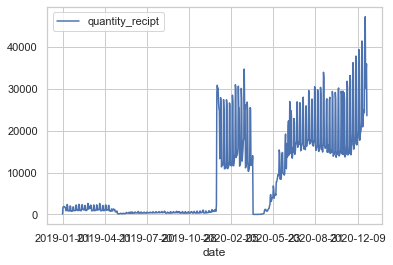

In [753]:
data1.plot()

array([[<AxesSubplot:title={'center':'quantity_recipt'}>]], dtype=object)

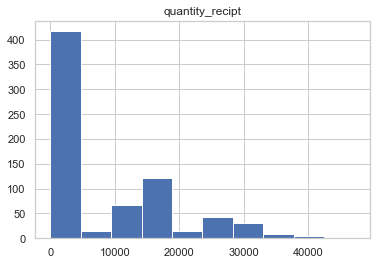

In [783]:
data1.hist()

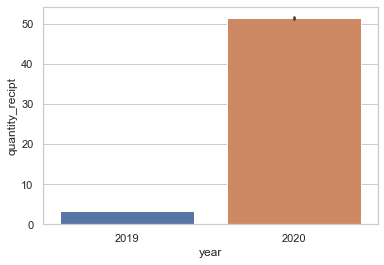

In [794]:
# Сравним по годам 
ax = sns.barplot(x="year", y="quantity_recipt",data=data)
#hue='BU'

In [748]:
data['quantity_recipt'].describe() #статистика по кол-ву чеков

count    196249.000000
mean         31.157519
std          36.549022
min           1.000000
25%           3.000000
50%          17.000000
75%          49.000000
max         769.000000
Name: quantity_recipt, dtype: float64

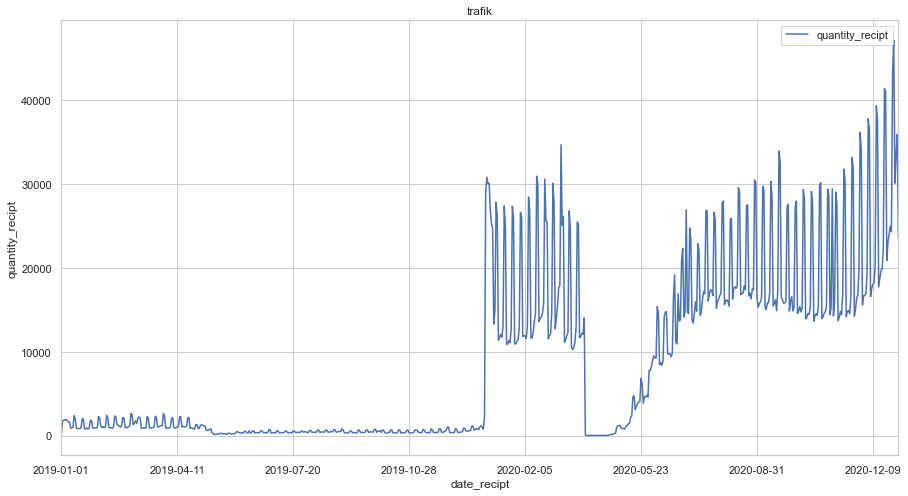

In [758]:
title = 'trafik'
ylabel='quantity_recipt'
xlabel='date_recipt'

ax = data1.plot(figsize=(15,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [759]:
data2=data1['2020-05-01':'2020-12-31']
data2.index=pd.to_datetime(data2.index)

In [760]:
data2.index.freq = 'D'

,quantity_recipt
date,
2020-05-01,262
2020-05-02,976
2020-05-03,1174
2020-05-04,1156
2020-05-05,1220
...,...
2020-12-27,47171
2020-12-28,30098
2020-12-29,33477


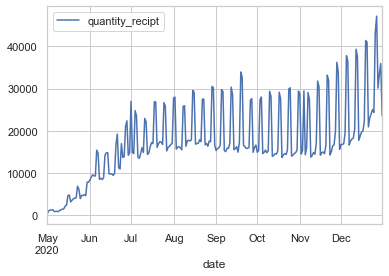

In [761]:
data2.plot()
df=data2
df

In [803]:
get_adf_kpss(df)


adf stat: -0.7652595643495687
adf p-value: 0.8291144660245786
kpss stat: 1.11698442596949
kpss p-value: 0.01
Врменной ряд имеет тренд и стационарность. Необходимо удалить тренд


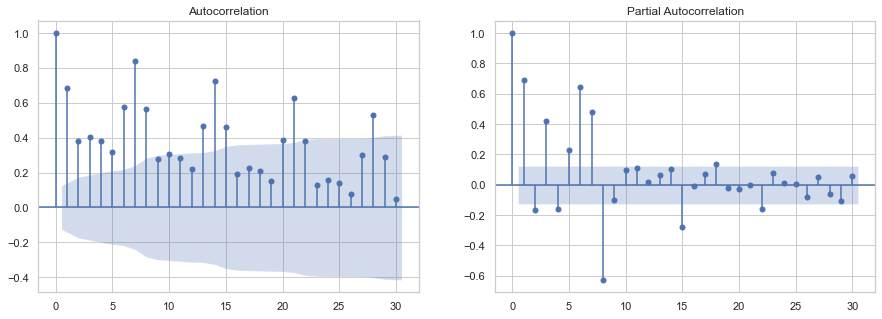

In [804]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

plot_acf(df, lags = 30, ax = ax1)
plot_pacf(df, lags = 30, ax = ax2)

plt.show()


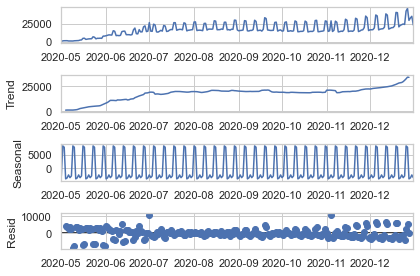

In [762]:
#ETS декомпозиция
result = seasonal_decompose(df, model='add')
result.plot();

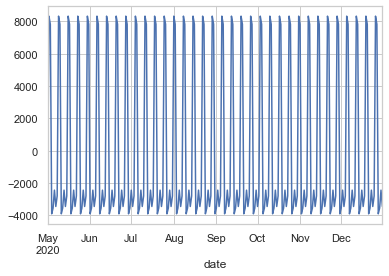

In [763]:
result.seasonal.plot();

In [764]:
#Запускаем pmdarima.auto_arima
# m=12
auto_arima(df, seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  245
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -2418.836
Date:                              Sun, 27 Mar 2022   AIC                           4847.673
Time:                                      11:25:59   BIC                           4865.159
Sample:                                           0   HQIC                          4854.715
                                              - 245                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    103.7245     31.109      3.334      0.001      42.753     164.696
ma.L1         -0.3653      0.078     -4.703      0.000      -0.518      -0.213
ma.L2         -0.4382      0.068     -6.438      0.000      -0.572      -0.305
ma.S.L12      -0.5749      0.053    -10.778      0.000      -0.679      -0.470
sigma2      2.335e+07      0.000    2.2e+11      0.000    2.34e+07    2.34e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                15.59
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.86e+26. Standard errors may be unstable.
"""

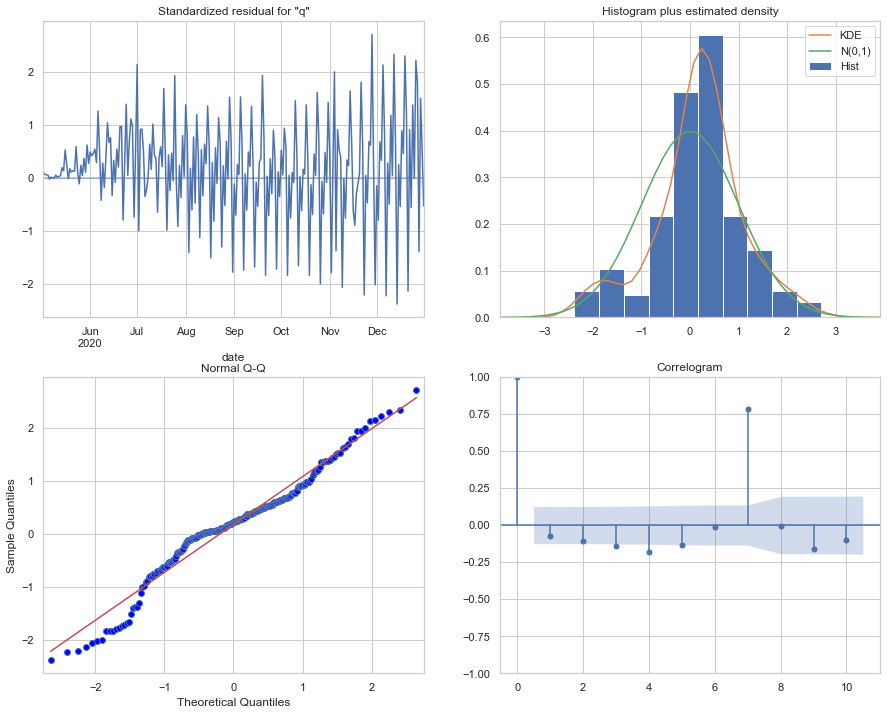

In [765]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [768]:
#делим на train/test
train = df.iloc[:len(df)-12]
train.head()



,quantity_recipt
date,
2020-05-01,262
2020-05-02,976
2020-05-03,1174
2020-05-04,1156
2020-05-05,1220


In [769]:
test = df.iloc[len(df)-12:]
test.head()

,quantity_recipt
date,
2020-12-20,41038
2020-12-21,20881
2020-12-22,23060
2020-12-23,23971
2020-12-24,24992


In [770]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [771]:
#Обучаем SARIMA(0, 1, 2)(0, 0, 1, 12)
model = SARIMAX(train['quantity_recipt'], order=(0, 1, 2), seasonal_order=(0, 0, 1, 12) )
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      quantity_recipt   No. Observations:                  233
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -2299.210
Date:                              Sun, 27 Mar 2022   AIC                           4606.420
Time:                                      11:26:17   BIC                           4620.207
Sample:                                  05-01-2020   HQIC                          4611.980
                                       - 12-19-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3138      0.099     -3.158      0.002      -0.509      -0.119
ma.L2         -0.4496      0.080     -5.650      0.000      -0.606      -0.294
ma.S.L12      -0.5434      0.059     -9.143      0.000      -0.660      -0.427
sigma2      2.724e+07   7.02e-10   3.88e+16      0.000    2.72e+07    2.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                15.04
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               3.71   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+32. Standard errors may be unstable.
"""

In [772]:
# Получаем прогнозируемые значения
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 1, 2)x(0, 0, 1, 12) ')
print(predictions)

2020-12-20    34611.831026
2020-12-21    27887.797458
2020-12-22    24273.913920
2020-12-23    24662.968190
2020-12-24    19535.984685
2020-12-25    19843.513294
2020-12-26    30405.127718
2020-12-27    28294.256641
2020-12-28    26969.948260
2020-12-29    24204.010554
2020-12-30    22963.620824
2020-12-31    17931.250675
Freq: D, Name: SARIMA(0, 1, 2)x(0, 0, 1, 12) , dtype: float64


In [773]:
# Сравниваем результаты
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['quantity_recipt'][i]}")

predicted=34611.83103, expected=41038
predicted=27887.79746, expected=20881
predicted=24273.91392, expected=23060
predicted=24662.96819, expected=23971
predicted=19535.98468, expected=24992
predicted=19843.51329, expected=24314
predicted=30405.12772, expected=43255
predicted=28294.25664, expected=47171
predicted=26969.94826, expected=30098
predicted=24204.01055, expected=33477
predicted=22963.62082, expected=35916
predicted=17931.25068, expected=23552


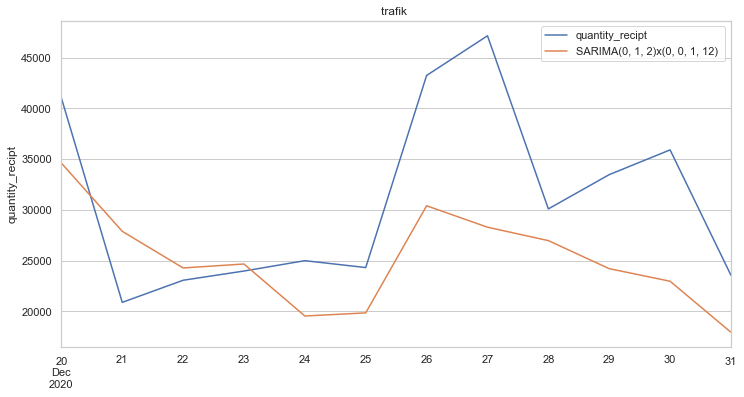

In [774]:
# Строим графики прогнозируемых и известных значений
title = 'trafik '
ylabel='quantity_recipt'
xlabel=''

ax = test['quantity_recipt'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [775]:
#Оцениваем качество модели с помощью MSE и RMSE
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['quantity_recipt'], predictions)
print(f'SARIMA(0, 1, 2)x(0, 0, [1], 12) MSE Error: {error:11.10}')

SARIMA(0, 1, 2)x(0, 0, [1], 12) MSE Error: 79889772.29


In [776]:
from statsmodels.tools.eval_measures import rmse
# rmse = root mse
error = rmse(test['quantity_recipt'], predictions)
print(f'SARIMA(0, 1, 2)x(0, 0, 1, 12) RMSE Error: {error:11.10}')

SARIMA(0, 1, 2)x(0, 0, 1, 12) RMSE Error:  8938.10787


In [781]:
# Обучаем модель на полных данных и прогнозируем будущее
model = SARIMAX(df['quantity_recipt'],order=(0, 1, 2),seasonal_order=(0, 0, 1, 12))
results = model.fit()

fcast = results.predict(len(df),len(df)+12,typ='levels').rename('SARIMA(0, 1, 2)x(0, 0, 1, 12) Forecast')

<AxesSubplot:>

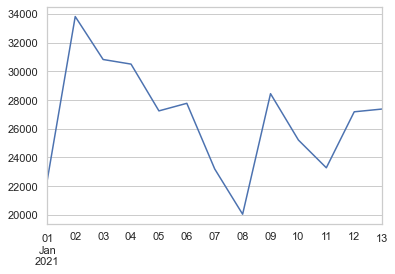

In [778]:
# График прогнозируемых данных
fcast.plot()

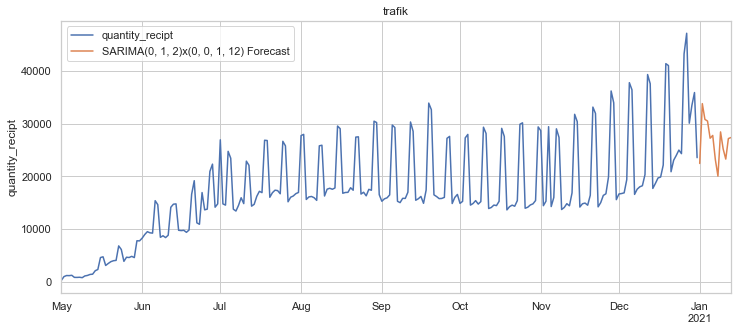

In [779]:
# График предсказаний и график исходных данных
title = 'trafik'
yl = 'quantity_recipt'
xl = ''

pl = df.plot(figsize=(12,5), title=title, legend=True)
fcast.plot(legend=True)
pl.autoscale(axis='x', tight=True)
pl.set(xlabel=xl, ylabel=yl);

In [798]:
# MAPE
mape = np.mean(np.abs(predictions - test['quantity_recipt'])/np.abs(test['quantity_recipt']))  
mape

0.22110745657231254